<p style="text-align: center">
<img src="../../assets/images/dtlogo.png" alt="Duckietown" width="50%">
</p>

# 🚙 💻 03 - Wheel encoder based odometry

"Odometry" is the problem of "measuring the path", or evolution of the pose in time, of the robot. 

We can solve the odometry problem by using the measurements from wheel encoders, and a so called "dead-reckoning" model, to estimate the evolution of the pose in time through an iterative procedure, such that:

<p style="text-align:center;"><img src="../../assets/images/odometry/odometry-1.png" width="500" alt="odometry-1"></p>   

$$ x_{k+1} = x_k + \Delta x_k $$
$$ y_{k+1} = y_k + \Delta y_k $$
$$ \theta_{k+1} = \theta_k + \Delta \theta_k $$

Where initial conditions ($x_0$, $y_0$, $\theta_0$) are assumed to be known. The increments can be calculated by:

1. **Determining the rotation of each wheel through the wheel encoder mesurements**

$$\Delta \phi_k = N_k \cdot \alpha$$

where $N_k$ is the number of pulses, or "ticks", measured from the encoders in the $k-th$ time interval, $\alpha = \frac{2 \pi}{N_{tot}}$ is the rotation per tick, and $N_{tot}$ the total number of ticks per revolution ($N_{tot} = 135$ for the wheel encoders we will be using). This relation is evaluated for each wheel, yielding $\Delta \phi_{l,k}$ and $\Delta \phi_{r,k}$ for the left and right wheels respectively.

2. **Deriving the total distance travelled by each wheel**

<p style="text-align:center;"><img src="../../assets/images/odometry/odometry-d.png" width="250" alt="odometry-d"></p> 

Assuming the wheel radii are the same (equal to $R$) for both wheels, the distance travelled by each wheel is given by:

$$ d_{l/r, k} = R \cdot \Delta \phi_{l/r,k}$$

3. **Finding the rotation and distance travelled by the robot (frame)**

<p style="text-align:center;"><img src="../../assets/images/odometry/odometry-2.png" width="250" alt="odometry-2"></p>    

Under the assumption of no slipping of the robot wheels, we can derive the distance travelled by the origin of the robot frame (point $A$) and the rotation of the robot $\Delta \theta$:

$$ d_{A, k} = \frac{d_{r,k} + d_{l,k}}{2} $$
$$ \Delta \theta_{k} = \frac{d_{r,k} - d_{l,k}}{2L}$$

4. **Expressing the robot motion in the world reference frame**

<p style="text-align:center;"><img src="../../assets/images/odometry/odometry-3.png" width="250" alt="odometry-3"></p>

Finally, we can express the estimated motion in the world reference frame and find:

$$ \Delta x_k = d_{A, k} \cos\theta_k $$
$$ \Delta y_k = d_{A, k} \sin\theta_k $$

# 🚙 💻 Let's get started!

You will write a function that produces an estimate of the pose of the Duckiebot, given mesurements from the wheel encoders and an initial position:

In [2]:
# Run and do not edit this magic cell. 
# It helps getting things to work throughout the Jupyter notebook - in particular importing changes in functions made in files other than this workspace.

%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

x0 = y0 = 0.0 # meters
theta0 = np.deg2rad(0) # radians

print(x0,y0, theta0)

0.0 0.0 0.0


## 1. Determining the rotation of each wheel through the wheel encoder mesurements

We have seen how to read wheel encoder data in the [wheel encoder tutorial](../../notebooks/03-Wheel-Encoders-Tutorial/wheel_encoders_tutorial.ipynb). We can now use this data to measure the rotation of each wheel. 

### Wheel encoder calibration factor

Remember that there are 135 ticks per revolution on the wheel encoders we are using. 

In [4]:
# Write the correct expressions 
import numpy as np 

N_tot = 135 # total number of ticks per revolution
alpha = 2 * np.pi / N_tot # wheel rotation per tick in radians

print(f"The angular resolution of our encoders is: {np.rad2deg(alpha)} degrees")

The angular resolution of our encoders is: 2.6666666666666665 degrees


Assume that at the current update the left and right motor encoders have produced the following measurements:

In [5]:
# Feel free to play with the numbers to get an idea of the expected outcome

ticks_left = 135
prev_tick_left = 0

ticks_right = -1
prev_tick_right = 0

How much did each wheel rotate? 

In [6]:
# How much would the wheels rotate with the above tick measurements? 

# Repetita iuvant: don't confuse degrees and radians when expressing angles
# Machines always use radians, humans make sense of degrees better. 
# Mixing these up is a very very common source of error!

delta_ticks_left = ticks_left - prev_tick_left # delta ticks of left wheel 
delta_ticks_right = ticks_right - prev_tick_right # delta ticks of right wheel 
rotation_wheel_left = alpha * delta_ticks_left # total rotation of left wheel 
rotation_wheel_right = alpha * delta_ticks_right # total rotation of right wheel 

print(f"The left wheel rotated: {np.rad2deg(rotation_wheel_left)} degrees")
print(f"The right wheel rotated: {np.rad2deg(rotation_wheel_right)} degrees")

The left wheel rotated: 360.0 degrees
The right wheel rotated: -2.6666666666666665 degrees


## 2. 🚙 💻 Evaluate distance travelled by each wheel

Now let's calculate the distance travelled by each wheel. It depends on the wheel radii. We need to determine them! We could use advanced odometry calibration procedures, but let's take it a step at the time. 

If you have a robot, take a ruler and measure your wheel radii (let's assume they are the same):

In [7]:
# What is the radius of your wheels (assuming they are identical)? 

R = 0.0318 # you could double check your robot but this is probably correct

Note: the default value used in simulation and on the robot is $R = 0.0318 \text{m}$.

In [8]:
# What is the distance travelled by each wheel?

d_left = R * rotation_wheel_left
d_right = R * rotation_wheel_right

print(f"The left wheel travelled: {d_left} meters")
print(f"The right wheel rotated: {d_right} meters")

The left wheel travelled: 0.19980529276831085 meters
The right wheel rotated: -0.0014800392056911916 meters


### 🚙 (Optional) Save your new value of `R`

If you have a Duckiebot, let's make sure it remembers its new wheel radius! 

Power you Duckiebot on, make sure it is connected to the network and you can ping it, then open a terminal **on your computer** and type:

    dts gui ROBOTNAME
    
    rosparam set /ROBOTNAME/kinematics_node/radius R-value
    
where `R-value` is the value of the wheel radius you measured (expressed in meters). You can then save it with: 

    rosservice call /ROBOTNAME/kinematics_node/save_calibration
    
and finally verify that it has been saved by opening the `ROBOTNAME.yaml` file in your Dashboard > File Manager > Calibrations > Kinematics page.

You can keep the terminal you just used open, so we can save the baseline measurement too. Let's keep going!

## 3. 🚙 💻 Find the rotation and distance travelled by the Duckiebot

If you have previoulsy set your robot's gain so that the wheels do not slip, the travelled distance of point $A$ (origin of the robot frame) will be given by the average of the distances travelled by the wheels:

In [9]:
# How much has the robot travelled? 

d_A = (d_left + d_right) / 2 # robot distance travelled in robot frame (meters)

print(f"The robot has travelled: {d_A} meters")

The robot has travelled: 0.09916262678130983 meters


To calculate the rotation of the robot we need to measure the baseline too - or the distance between the center of the two wheels: 

<p style="text-align:center;"><img src="../../assets/images/odometry/odometry-baseline.png" width="300" alt="odometry-baseline"></p>  

If you have a robot, take a ruler and measure it! 

In [10]:
# What is the baseline length of your robot? 

baseline_wheel2wheel = 0.1 #  This is probably correct but feel free to double check 

Note: the default value, and that used in simulation, is $baseline = 0.1m$.

We are now ready to calculate the rotation of the Duckiebot:

In [11]:
# Of what angle has the robot rotated? 

Delta_Theta = (d_right - d_left) / baseline_wheel2wheel # [radians]

print(f"The robot has rotated: {np.rad2deg(Delta_Theta)} degrees")

The robot has rotated: -115.328 degrees


### 🚙 (Optional) Save your new value of `baseline`

Let's make sure it remembers its new wheel baseline! 

Power you Duckiebot on, make sure it is connected to the network and you can ping it, then open a terminal **on your computer** and type:

    dts start_gui_tools ROBOTNAME
    
    rosparam set /ROBOTNAME/kinematics_node/baseline baseline-value
    
where `baseline-value` is the value of `baseline_wheel2wheel` you just measured (expressed in meters). You can then save it with: 

    rosservice call /ROBOTNAME/kinematics_node/save_calibration
    
and finally verify that it has been saved by opening the `ROBOTNAME.yaml` file in your Dashboard > File Manager > Calibrations > Kinematics page.

# 💻 🚙 Write the odometry function

Now it is time to write the functions that will actually be running on the robot. 

You will write two functions:

1. A function that calculates the rotation of a wheel given a message from the wheel encoders and the previous number of ticks measured;

2. The actual odometry function, that will receive as inputs the kinematic model parameters, the pose estimate at the previous iteration, and the rotation of each wheel. The initial position is assumed to be $q_0 = [0,0,0]^T$.

## Calculating the rotation of each wheel

Implement the function `delta_phi` inside the file [odometry.py](../../packages/encoder_pose/include/odometry/odometry.py).

This function should output the wheel rotation (in radians) since last measurements, receiving as input the current and previous update wheel encoder readings. This function is called from a ROS node [encoder_pose_node.py](../../packages/encoder_pose/src/encoder_pose_node.py) which we have written, but you might want to take a look at to make sure you understand what's going on. 

## Estimating the odometry

Similarly, implement the function `estimate_pose` inside the file [odometry.py](../../packages/encoder_pose/include/odometry/odometry.py)..
This function computes the `(x, y, theta)` estimate by aggregating computed wheel rotations and the (known) geometry of the robot.

### Test the `pose_estimation()` function

Unit tests are useful to check if a piece of code does its intended job. Although the interaction of different functions might yield surprises even when each function produces the expected outcome, it is good pratice to test them in isolation before prime time! These are called "unit tests", and:

> If it ain't tested, it's broken.
>
> --Roboticists, level 9

Let's see if the function you wrote above passes the following test!

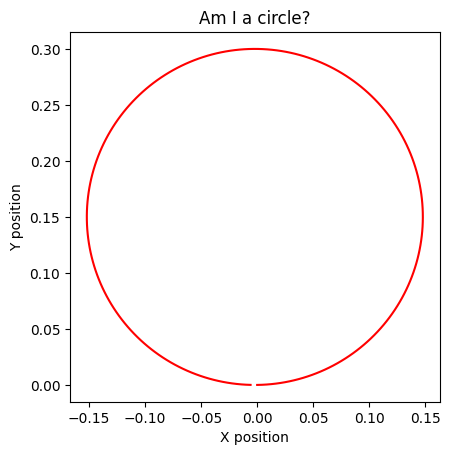

In [14]:
import sys
sys.path.append('../../tests')
sys.path.append('../../packages/encoder_pose/include/')
from unit_test import UnitTestOdometry

from odometry import estimate_pose


# UnitTestOdometry tests the `pose_estimation` function.
# The test is successful if you get a circle in the plot. 
# Anything different from a circle indicated that the odometry function has something wrong.

UnitTestOdometry(R, baseline_wheel2wheel, estimate_pose)

# 💻 🚙 Running Everything

Let's now see how the odometry estimation is working in practice. 



Follow the instructions in the [README](../../README.md) to run the code and the `noVNC` browser.

Double-click on the "Odometry" icon on the Desktop

<p style="text-align:center;"><img src="../../assets/images/odometry/odometry_icon.png" width="100" alt="test-odometry-icon"></p>  

You will see three things opening: 

- a terminal
- a pre-configured RVIZ window
- a virtual joystick

<figure>
  <div style="text-align:center;">
  <img src="../../assets/images/odometry/od-sim-startup.png" width="400">
  <p>Starting the Odometry activity.</p>
  </div>
</figure>

In the RVIZ window you will see what your robot sees, and a reference frame in the gridmap. That frame represents the position and orientation of your robot, calculated _according to the `pose_estimation` and `delta_phi` functions written above_ (they are beliefs, not "real" states).

**Note**: it may take some time (>30s) for the images and the odometry to appear, depending on the specifications of your host machine.  

Tips: 

    - You can change the graphical settings of the reference frame (bigger, shorter, more or less frequently updated, etc.) through the Odometry > Shape options in the top left quadrant of the RVIZ window;
    
    - You can press `Alt` while clicking and dragging anywhere in the RVIZ terminal to move the window;
    
    - VNC opens with the resolution of your browser window when you launch it. If things look crammed, put your browser in full screen and re-copy and paste the URL. 
    
    - The terminal on your computer where you ran `dts code workbench` will be streaming some debugging data. 
    
Click on the virtual joystick and start driving. You will see the marker move too according to the wheel encoder data that the robot is receiving. You can monitor these (and other) messages by following the procedure learned in the [wheel encoders tutorial](../02-Wheel-Encoders/wheel_encoders.ipynb). 

Drive a loop. Get back to the initial position and look at the resulting odometry. Is your robot's _belief_ accurate? Why, or why not? 


<!--
<p style="text-align:center;"><img src="../../assets/images/odometry/sim-odom-complete.png" width="500" alt="sim-odometry-complete"></p> 
-->

<div style="text-align:center;">
        <div style="text-align:center;">
            <img src="../../assets/images/odometry/sim-odom-complete.png" width="300" />
            <img src="../../assets/images/odometry/od-sim-tour.png" width="300" />
            <p>Odometry with different markers on different loops.</p>
        </div>
</div>

If you do not have a robot, you can now proceed to the [PID control activity](../05-PID-Control/PID_controller.ipynb). If you have a robot instead, buckle your Duckies up and continue reading, it's time to have some more fun!

## 🚙 Running the odometry activity on the Duckiebot 

The procedure for running this activity on your Duckiebot is very similar to above, and the same tips apply. 

0. Make sure your Duckiebot is powered on, charged, and connected to the network. Moreover, make sure you have calibrated your robots kinematic parameters. 

1. Computer -> Open terminal

        dts code build
        
        dts code workbench -b ROBOTNAME  


2. Open VNC on you browser. 

3. Double-click on the "Odometry" icon on the Desktop 

You will see three things opening: 

- a terminal
- a pre-configured RVIZ window
- a virtual joystick

In the RVIZ window you will see what your robot sees, and a marker in the gridmap. That reference frame represents the position and orientation of your robot _according to the `pose_estimation` and `delta_phi` functions written above_.
    
4. Click on the virtual joystick and start driving. You will see the marker move too according to the wheel encoder data that the robot is receiving. You can monitor these (and other) messages by following the procedure learned in the [wheel encoders tutorial](../03-Wheel-Encoders-Tutorial/wheel_encoders_tutorial.ipynb). 

5. Drive as you wish. We suggest driving in your Duckietown for two reasons: (a) you should have calibrated the gain of your motors so not to slip and (b) you will have a reference of the approximate driven path. Or you can drive around your house; or do both. Whatever you do, get back to the initial position (approximately) and look at the resulting odometry. Is your robot's _belief_ accurate? Why? 

6. When you are satisfied with your experience and your odometry, `Ctrl-C` the terminal on your computer to stop VNC, or `Ctrl-C` your open terminal in VNC to go back to the desktop. 

Do you want to modify your odometry functions before proceeding? Update the `pose_estimation` and `delta_phi` functions and re-launch `dts code workbench -b ROBOTNAME`. 

<div style="text-align:center;">
        <div style="text-align:center;">
            <img src="../../assets/images/odometry/odometry-real-2.png" width="300" alt="successful-test-odometry-real" />
            <img src="../../assets/images/odometry/less-good-odometry.png" width="300" />
            <p>DB21 Duckiebot good and less good odometries.</p>
        </div>
</div>